<h1><center> <font color='black'> Business Data Analytics - Practice Session_10 </font></center></h1>
<h2><center> <font color='black'> Uplift modeling</font></center></h3>
<h2><center> <font color='black'> University of Tartu - Spring 2020</font></center></h3>

# Introduction:

* If you are simply building a Machine Learning (or `predictive`) model and executing promotion campaigns to the customers who are predicted to buy a product, for example, it is not efficient.

* There are some customers who will buy a product anyway even without promotion campaigns (called `Sure things`).

* It is even possible that the campaign triggers some customers to churn (called `Do Not Disturbs` or `Sleeping Dogs`).


## The solution is Uplift Modeling.

### What is Uplift Modeling?

* **Uplift Modeling** is a Machine Learning technique to find which customers (individuals) should be `targeted (treated`) and which customers should not be targeted.

* Uplift Modeling is also known as persuasion modeling, incremental modeling, treatment effects modeling, true lift modeling, net modeling.

* Applications of Uplift Modeling for business include:
    * Increase revenue by finding which customers should be targeted for advertising/marketing campaigns and which customers should not.
    * Retain revenue by finding which customers should be contacted to prevent churn and which customers should not.

* Uplift models predict incremental value, or `lift`: **prescriptive model**

 

\begin{align*}\text{Lift} = P(\text{buy} | \text{treatment} ) - P(\text{buy} | \text{no treatment} ),\end{align*}
 

* as opposed to outcome models, which simply predict the outcome. **predictive model**

 

\begin{align*}\text{Outcome} = P(\text{buy} | \text{treatment} ).\end{align*}
 

* We use `buy` here for simplicity, but this can be replaced with any outcome you desire. How an individual acts when treated and untreated categorizes them into one of the four following “types”:

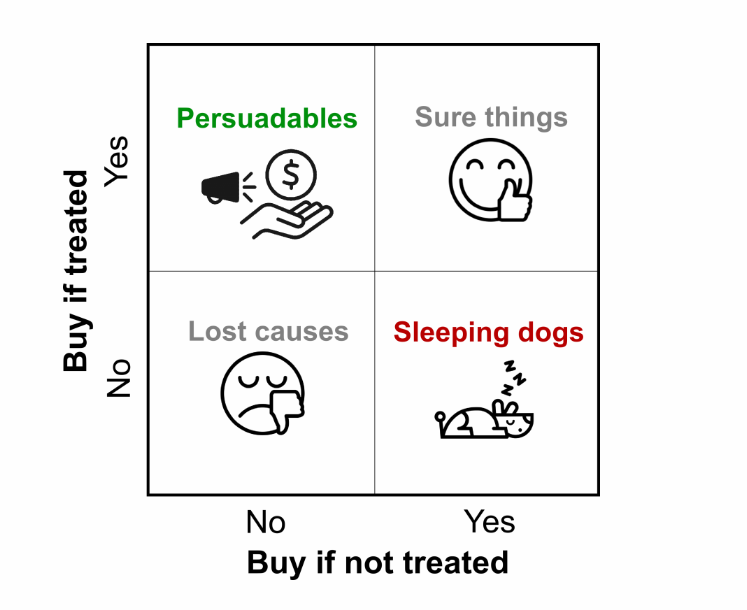

In [0]:
from IPython.display import Image
Image(filename='lab.png')

* In an ideal world we would be able to identify each individual by their `type`, and we would target the so-called `persuadables` alone, as this is where we can get the most return on our investment. And we definitely wouldn’t want to target the `sleeping dogs`. 


* In reality we cannot hope to discover the **type of person** an individual is, because we can only show them one treatment! Instead, we look to the power of statistics and machine learning to tell us what groups `or segmants` of **similar people** would do on average. 


* This is what **uplift** gives us. `Each individual gets a lift score between $-1$ and $1$, and this is used to determine who to target.` If we have an accurate model, those with higher positive scores will respond better to the treatment and therefore should be targeted, whereas those with low negative scores will respond badly and should not be targeted.

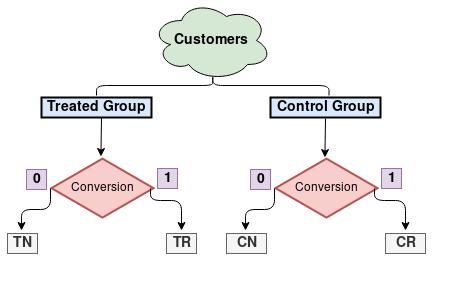

In [0]:
from IPython.display import Image
Image(filename='g.png')

* **Segmentation** helps Growth Hackers to increase conversion and hence be cost-efficient. But imagine a case that you are about to launch a promotional campaign and you know which segment you want to target. `Do you need to send the offer to everyone?`


## Which group to target?

* The answer is no. We can summarize the segments based on this approach like below:

    * **Treatment Responders (TR):** Customers that will purchase only if they receive an offer
    * **Treatment Non-Responders (TN):** Customer that won’t purchase in any case
    * **Control Responders (CR):** Customers that will purchase without an offer
    * **Control Non-Responders (CN):** Customers that will not purchase if they don’t receive an offer
    
  
* The picture is very obvious. You need to target **Treatment Responders (TR)** and **Control Non-Responders (CN)**. Since they won’t purchase unless you give an offer, these groups are boosting your uplift in promotional campaigns. On the other hand, you need to avoid targeting Treatment Non-Responders (TN) and Control Responders (CR). 


## How to segment custmoers?

* There is one last simple thing to do. We need to identify which customers fall into which buckets. The answer is Uplift Modeling. It has two simple steps:
    * Predict the probabilities of being in each group for all customers: we are going to build a `multi-classification` model for that.
    * We will calculate the uplift score. Uplift score formula is:
    
    \begin{align*}\text{Uplift} = P_\text{TR} +  P_\text{CN} -  P_\text{TN} -  P_\text{CR} .\end{align*}

    

* We will sum up the probability of being TR and CN and subtract the probability of falling into other buckets. `The higher score means higher uplift.`



## Data set
* Alright, let’s see how we can implement this with an example. We will be using a dataset of customers who received `Discount` and `Buy One Get One` offers and how they reacted. We also have a control group that didn’t receive anything.


### We start with importing the libraries and functions we need

In [0]:
from __future__ import division

from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans


In [0]:
!pip install chart_studio

     |████████████████████████████████| 71kB 2.1MB/s 


In [0]:
import chart_studio.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

In [0]:
import sklearn
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import warnings
warnings.filterwarnings("ignore")

In [0]:
df_data = pd.read_csv('response_data.csv')
df_data.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


* Column descriptions are as follows:

1. **recency:** months since last purchase
2. **history:** value of the historical purchases
3. **used_discount/used_bogo:** indicates if the customer used a discount or buy one get one before
4. **zip_code:** class of the zip code as Suburban/Urban/Rural
5. **is_referral:** indicates if the customer was acquired from referral channel
6. **channel:** channels that the customer using, Phone/Web/Multichannel
7. **offer:** the offers sent to the customers, `Discount, But One Get One, or No Offer`

In [0]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


# 1. Predict the prob of being in each group:


### Multi-classification Model for Predicting the Uplift Score

* Currently, our **label** is if a customer converted or not (1 or 0) `(conversion)`.

* We need to create four classes for `TR, TN, CR, and CN.` We know that the customers `who received discount and bogo offers are Treatment` and the rest is control. Let’s create a campaign_group column make this info visible:

In [0]:
df_data['campaign_group'] = 'treatment'
df_data.loc[df_data.offer == 'No Offer', 'campaign_group'] = 'control' # filter for control group
df_data.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion,campaign_group
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0,treatment
1,6,329.08,1,1,Rural,1,Web,No Offer,0,control
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0,treatment
3,9,675.83,1,0,Rural,1,Web,Discount,0,treatment
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0,treatment


* Perfect, now we need to create our new labels:


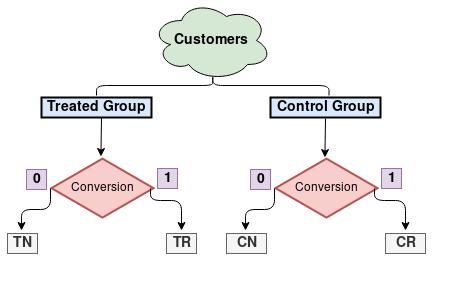

In [0]:
from IPython.display import Image
Image(filename='g.png')

conversion, campaign group, group\\

* 0                - treatment  >>>>>>>> 2
* 0                - control    >>>>>>>> 0
* 1                - treatment  >>>>>>>> 3
* 1                - control    >>>>>>>> 1

In [0]:

df_data['target_class'] = 0 #CN 
df_data.loc[(df_data.campaign_group == 'control') & (df_data.conversion > 0),'target_class'] = 1 #CR
df_data.loc[(df_data.campaign_group == 'treatment') & (df_data.conversion == 0),'target_class'] = 2 #TN
df_data.loc[(df_data.campaign_group == 'treatment') & (df_data.conversion > 0),'target_class'] = 3 #TR
df_data.head(10)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion,campaign_group,target_class
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0,treatment,2
1,6,329.08,1,1,Rural,1,Web,No Offer,0,control,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0,treatment,2
3,9,675.83,1,0,Rural,1,Web,Discount,0,treatment,2
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0,treatment,2
5,6,134.83,0,1,Surburban,0,Phone,Buy One Get One,1,treatment,3
6,9,280.20,1,0,Surburban,1,Phone,Buy One Get One,0,treatment,2
7,9,46.42,0,1,Urban,0,Phone,Buy One Get One,0,treatment,2
8,9,675.07,1,1,Rural,1,Phone,Discount,0,treatment,2
9,10,32.84,0,1,Urban,1,Web,Buy One Get One,0,treatment,2


* In this example, the mapping of the classes are below:

1. 0 -> Control Non-Responders
2. 1 -> Control Responders
3. 2 -> Treatment Non-Responders
4. 3 -> Treatment Responders

* There is one small feature engineering step before training our model. We will create clusters from history column and apply get_dummies for converting categorical columns into numerical:

In [0]:
gr = ['CN', 'CR', "TN", "TR"]
i=0
for d in df_data.target_class.value_counts():
  print(f"{gr[i]}: {d}\n")
  i+=1

CN: 35562

CR: 19044

TN: 7132

TR: 2262



In [0]:

gr = ['CN', 'CR', "TN", "TR"]
i=0
for d in df_data.target_class.value_counts()/len(df_data):
  print(f"{gr[i]}: {d}\n")
  i+=1

CN: 0.55565625

CR: 0.2975625

TN: 0.1114375

TR: 0.03534375



In [0]:
# create 4 clusters using kmeans based on the history column
kmeans = KMeans(n_clusters=5) # n-1
kmeans.fit(df_data[['history']]) # value of the historical purchases
df_data['history_cluster'] = kmeans.predict(df_data[['history']])
df_data.head(10)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion,campaign_group,target_class,history_cluster
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0,treatment,2,3
1,6,329.08,1,1,Rural,1,Web,No Offer,0,control,0,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0,treatment,2,0
3,9,675.83,1,0,Rural,1,Web,Discount,0,treatment,2,1
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0,treatment,2,3
5,6,134.83,0,1,Surburban,0,Phone,Buy One Get One,1,treatment,3,3
6,9,280.20,1,0,Surburban,1,Phone,Buy One Get One,0,treatment,2,0
7,9,46.42,0,1,Urban,0,Phone,Buy One Get One,0,treatment,2,3
8,9,675.07,1,1,Rural,1,Phone,Discount,0,treatment,2,1
9,10,32.84,0,1,Urban,1,Web,Buy One Get One,0,treatment,2,3


In [0]:
#function to order clusters
def order_cluster(cluster_field_name, target_field_name, df, ascending):
    
    new_cluster_field_name = 'new_' + cluster_field_name
    
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    
    df_new['index'] = df_new.index
    
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    
    return df_final


In [0]:
df_data = order_cluster('history_cluster', 'history',df_data,True)
df_data.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion,campaign_group,target_class,history_cluster
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0,treatment,2,0
1,2,45.34,1,0,Urban,0,Web,Buy One Get One,0,treatment,2,0
2,6,134.83,0,1,Surburban,0,Phone,Buy One Get One,1,treatment,3,0
3,9,46.42,0,1,Urban,0,Phone,Buy One Get One,0,treatment,2,0
4,10,32.84,0,1,Urban,1,Web,Buy One Get One,0,treatment,2,0


In [0]:
## Data for model

In [0]:
#creating a new dataframe as model and dropping columns that defines the label
df_model = df_data.drop(['offer','campaign_group','conversion'],axis=1)
#convert categorical columns
df_model = pd.get_dummies(df_model)

df_model.head()

,recency,history,used_discount,used_bogo,is_referral,target_class,history_cluster,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
0,10,142.44,1,0,0,2,0,0,1,0,0,1,0
1,2,45.34,1,0,0,2,0,0,0,1,0,0,1
2,6,134.83,0,1,0,3,0,0,1,0,0,1,0
3,9,46.42,0,1,0,2,0,0,0,1,0,1,0
4,10,32.84,0,1,1,2,0,0,0,1,0,0,1


#### Let’s fit our model and get the probabilities for each class





In [0]:
#create feature set and labels
X = df_model.drop(['target_class'],axis=1)
y = df_model.target_class

#splitting train and test groups
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=56)

#fitting the model and predicting the probabilities
xgb_model = xgb.XGBClassifier().fit(X_train, y_train)
class_probs = xgb_model.predict_proba(X_test)

* Variable class_probs possesses the probabilities for each customer. Let’s check out an example:

In [0]:
gr = ['CN', 'CR', "TN", "TR"]
i=0
for d in class_probs[0]:
  print(f"{gr[i]}: {d}\n")
  i+=1

CN: 0.2811277508735657

CR: 0.04322883114218712

TN: 0.541674792766571

TR: 0.13396860659122467



In [0]:
class_probs[0]


array([0.28112775, 0.04322883, 0.5416748 , 0.1339686 ], dtype=float32)

In this example, the mapping of the classes are below:

* 0 -> Control Non-Responders: 28 %

* 1 -> Control Responders: 4 %

* 2 -> Treatment Non-Responders:  54 %
 
* 3 -> Treatment Responders: 13 %


In [0]:
0.28112775 +   0.1339686 - 0.04322883 -  0.5416748  

-0.16980728

* For this specific customer, we can map the probabilities as below:
    * 0 -> Control Non-Responders: 28.7 %
    * 1 -> Control Responders: 2.1 %
    * 2 -> Treatment Non-Responders:  59.4 %
    * 3 -> Treatment Responders: 9.7 %

    
* So the **uplift score** for this customer is:

    \begin{align*}\text{Uplift} = P_\text{CN} +  P_\text{TR} -  P_\text{TN} -  P_\text{CR} .\end{align*}
    \begin{align*}\text{Uplift} = 0.28112775 +   0.1339686 - 0.04322883 -  0.5416748   =-0.16980728.\end{align*}
    



* Let’s apply this to all users and calculate the uplift score:

## Calculate uplift score to all customers

In [0]:
#probabilities for all customers
overall_proba = xgb_model.predict_proba(df_model.drop(['target_class'],axis=1))

#assign probabilities to 4 different columns
df_model['proba_CN'] = overall_proba[:,0] 
df_model['proba_CR'] = overall_proba[:,1] 
df_model['proba_TN'] = overall_proba[:,2] 
df_model['proba_TR'] = overall_proba[:,3]

#calculate uplift score for all customers
df_model['uplift_score'] = df_model.eval('proba_CN + proba_TR - proba_TN - proba_CR')

#assign it back to main dataframe
df_data['uplift_score'] = df_model['uplift_score']


In [0]:
df_model.head()

,recency,history,used_discount,used_bogo,is_referral,target_class,history_cluster,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,proba_CN,proba_CR,proba_TN,proba_TR,uplift_score
0,10,142.44,1,0,0,2,0,0,1,0,0,1,0,0.325158,0.025527,0.575012,0.074303,-0.201078
1,2,45.34,1,0,0,2,0,0,0,1,0,0,1,0.287451,0.049933,0.529437,0.133179,-0.158740
2,6,134.83,0,1,0,3,0,0,1,0,0,1,0,0.304827,0.034571,0.547231,0.113371,-0.163604
3,9,46.42,0,1,0,2,0,0,0,1,0,1,0,0.294727,0.026143,0.575942,0.103188,-0.204170
4,10,32.84,0,1,1,2,0,0,0,1,0,0,1,0.304813,0.017120,0.598381,0.079687,-0.231002


* By running the code above, we added a uplift_score column in our main dataframe and it looks like below:

In [0]:
df_data.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion,campaign_group,target_class,history_cluster,uplift_score
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0,treatment,2,0,-0.201078
1,2,45.34,1,0,Urban,0,Web,Buy One Get One,0,treatment,2,0,-0.158740
2,6,134.83,0,1,Surburban,0,Phone,Buy One Get One,1,treatment,3,0,-0.163604
3,9,46.42,0,1,Urban,0,Phone,Buy One Get One,0,treatment,2,0,-0.204170
4,10,32.84,0,1,Urban,1,Web,Buy One Get One,0,treatment,2,0,-0.231002


## Model Evaluation

* It is time to check the most critical part of having this model. `Is the model really working?` It is a bit hard to evaluate the true performance of uplift modeling. We will check how the uplift is changing across uplift score quantiles to see if we can use the model in real life.



* To evaluate our model, we will create two different groups and compare them with `benchmark`. Groups are:
    * **High Uplift Score:** Customers have uplift score > 3rd quantile
    * **Low Uplift Score:** Customers have uplift score < 2nd quantile
    
    
* We are going to compare:
    * Conversion uplift
    * Revenue uplift per target customer to see if our model can make our actions more efficient.
    
    
* Here is our benchmark for the discount campaign.

## 1. Benchmark

1. We will  calculate uplift score to the orignal dataset without calculating any lift scores or making any clustering

In [0]:
#function for calculating the uplift
def calc_uplift(df):
    avg_order_value = 25
    
    #calculate conversions for each offer type
    base_conv = df[df.offer == 'No Offer']['conversion'].mean() # no offer 0.106
    disc_conv = df[df.offer == 'Discount']['conversion'].mean() # discount  0.182
    bogo_conv = df[df.offer == 'Buy One Get One']['conversion'].mean() # buy one get one  0.151
    
    #calculate conversion uplift for discount and bogo
    disc_conv_uplift = disc_conv - base_conv   # uplift = treated - contolr
    bogo_conv_uplift = bogo_conv - base_conv   # uplift = treated - contolr
    
    #calculate order uplift
    disc_order_uplift = disc_conv_uplift * len(df[df.offer == 'Discount']['conversion'])
    bogo_order_uplift = bogo_conv_uplift * len(df[df.offer == 'Buy One Get One']['conversion'])
    
    #calculate revenue uplift
    disc_rev_uplift = disc_order_uplift * avg_order_value
    bogo_rev_uplift = bogo_order_uplift * avg_order_value
    
    print(f"Total Targeted Customer Count: {len(df_data[df_data.offer == 'Discount']['conversion'])}")
    print('Discount Conversion Uplift: {0}%'.format(np.round(disc_conv_uplift*100,2))) # uplitf score %
    print('Discount Order Uplift: {0}'.format(np.round(disc_order_uplift,2)))
    print('Discount Revenue Uplift: ${0}\n'.format(np.round(disc_rev_uplift,2)))
    
    if len(df[df.offer == 'Buy One Get One']['conversion']) > 0:
          
        print('-------------- \n')
        print(f"Total Targeted Customer Count: { len(df[df.offer == 'Buy One Get One']['conversion'])}")
        print('BOGO Conversion Uplift: {0}%'.format(np.round(bogo_conv_uplift*100,2))) # uplift sore
        print('BOGO Order Uplift: {0}'.format(np.round(bogo_order_uplift,2)))
        print('BOGO Revenue Uplift: ${0}'.format(np.round(bogo_rev_uplift,2)))     

In [0]:
df_data2 = pd.read_csv('response_data.csv')
df_data2.head()
calc_uplift(df_data2)

Total Targeted Customer Count: 21307
Discount Conversion Uplift: 7.66%
Discount Order Uplift: 1631.89
Discount Revenue Uplift: $40797.35

-------------- 

Total Targeted Customer Count: 21387
BOGO Conversion Uplift: 4.52%
BOGO Order Uplift: 967.4
BOGO Revenue Uplift: $24185.01


## calculte uplift score to the generated data using xgboost model

In [0]:
df_data_lift = df_data.copy()
uplift_q_75 = df_data_lift.uplift_score.quantile(0.75)
df_data_lift = df_data_lift[(df_data_lift.offer != 'Buy One Get One') & (df_data_lift.uplift_score > uplift_q_75)].reset_index(drop=True)


#calculate the uplift
calc_uplift(df_data_lift)

Total Targeted Customer Count: 21307
Discount Conversion Uplift: 12.18%
Discount Order Uplift: 636.28
Discount Revenue Uplift: $15907.06



* The results are great. Discount Conversion Uplift is 30% better.

* We will check the same numbers for the group with the lower uplift score:

In [0]:
df_data_lift = df_data.copy()
uplift_q_5 = df_data_lift.uplift_score.quantile(0.5)

df_data_lift = df_data_lift[(df_data_lift.offer != 'Buy One Get One') & (df_data_lift.uplift_score < uplift_q_5)].reset_index(drop=True)
#calculate the uplift
calc_uplift(df_data_lift)


Total Targeted Customer Count: 21307
Discount Conversion Uplift: 5.8%
Discount Order Uplift: 624.84
Discount Revenue Uplift: $15621.08



* As expected, revenue uplift per targeted customer decreased to $3$%. 


* By using this model, we can easily make our campaign more efficient by:
    * Targeting specific segments based on the uplift score
    * Trying different offers based on customer’s uplift score